<span style='font-family:Georgia; font-size:40px; font-weight:bold;text-align:center;'>Heart Disease Prediction</span>

<span style='font-family:Georgia; font-size:20px; font-weight:bold;'>Setup Development Environment</span>

<div style='font-family:Georgia; font-size:16px; font-weight:500;'>
    Create and activate a virtual environment in Windows
    <li><code>python -m venv .venv && .venv\Scripts\activate</code></li>
    Install `ipykernel` and `notebook`
    <li><code>pip install ipykernel notebook</code></li>
    Register the environment as a new kernel
    <li><code>python -m ipykernel install --user --name=heart-disease</code></li>
    Lauch the notebook server and choose the kernel `heart-disease`
    <li><code>jupyter notebook</code></li>
    <blockquote style="border-left: 5px solid #ccc; padding: 10px 20px; background: #f9f9f9; color: #555;">
        It is important to setup a virtual environment and install all your packages there for reproducibility. Different environments have different configuration. The packages installed in your local environment may be different from the ones on Google Colab or Kaggle. Provide your packages with the requirements.txt file: <code>pip freeze > requirements.txt</code>
</blockquote>

</div>

<span style='font-family:Georgia; font-size:20px; font-weight:bold;'>Feature Engineering</span>

<div style='font-family:Georgia; font-size:16px; font-weight:500;'>
    Included the following features to the dataset after some research:
    <ol>
        <li><span style='font-weight:bold;'>Heart Stress Index</span></li>
       \[ \frac{\text{MaxHR}}{\text{Age} + \varepsilon} \cdot (1  + \text{ExerciseAngina}) \]
        Where: \[
         \text{ExerciseAngina} = 
        \begin{cases}
        1 & \text{if Yes} \\
        0 & \text{otherwise}
        \end{cases}
        \]
        \[ \varepsilon = 1 \times 10^{-6} \]
        <li style='font-weight:bold;'>Cholesterol to Age Ratio</li>
        \[ \frac{\text{Cholesterol}}{\text{Age} + \varepsilon} \]
        <li style='font-weight:bold;'>Risk Score</li>
        \[ \text{OldPeak} \cdot \text{SlopeIndex} \]
        Where: \[
        \text{SlopeIndex} = 
        \begin{cases}
        1 & \text{if } \text{ST\_Slope} = \text{Up} \\
        2 & \text{if } \text{ST\_Slope} = \text{Flat} \\
        3 & \text{if } \text{ST\_Slope} = \text{Down}
        \end{cases}
        \]
        <li style='font-weight:bold;'>Blood Pressure and Heart Rate Interaction</li>
        \[ \text{RestingBP} \cdot \text{MaxHR}  \]
        <li style='font-weight:bold;'>Age and Cholesterol Interaction</li>
        \[ \text{Age} \cdot \text{Cholesterol} \]
         <li style='font-weight:bold;'>Old Peak to MaxHR Ratio</li>
        \[ \frac{\text{Oldpeak}}{\text{MaxHR} + \varepsilon} \]
         <li style='font-weight:bold;'>Blood Pressure and Age Interaction</li>
        \[ \text{RestingBP} \cdot \text{Age} \]
        <li style='font-weight:bold;'>Age MaxHR Interaction</li>
        \[ \text{Age} \cdot \text{MaxHR} \]
        <li style='font-weight:bold;'>Cholesterol Oldpeak Interaction</li>
        \[ \text{Cholesterol} \cdot \text{Oldpeak} \]
        <li style='font-weight:bold;'>MaxHR ExerciseAngina Interaction</li>
        \[ \text{MaxHR} \cdot \text{ExerciseAngina} \]
        <li style='font-weight:bold;'>Framingham Proxy Score</li>
        \[ 
        0.02 \cdot \text{Age} +
        0.015 \cdot \text{Cholesterol} +
        0.03 \cdot \text{RestingBP} +
        0.04 \cdot \text{Oldpeak} +
        0.1 \cdot \text{FastingBS}
        \]    
    </ol>
    
    
</div>

In [1]:
def create_features(df):
    df['HeartStressIndex'] = (df['MaxHR'] / (df['Age'] + 1e-6)) * (1 + df['ExerciseAngina'].map({'Y': 1, 'N': 0}).fillna(0))
    df['CholesterolToAgeRatio'] = df['Cholesterol'] / (df['Age'] + 1e-6)
    df['RiskScore'] = df['Oldpeak'] * df['ST_Slope'].map({'Up': 1, 'Flat': 2, 'Down': 3}).fillna(0)
    df['BP_HR_Interaction'] = df['RestingBP'] * df['MaxHR']
    df['Age_Cholesterol_Interaction'] = df['Age'] * df['Cholesterol']
    df['Oldpeak_MaxHR_Ratio'] = df['Oldpeak'] / (df['MaxHR'] + 1e-6)
    df['BP_Age_Interaction'] = df['RestingBP'] * df['Age']
    df['Age_MaxHR_Interaction'] = df['Age'] * df['MaxHR']
    df['Cholesterol_Oldpeak_Interaction'] = df['Cholesterol'] * df['Oldpeak']
    df['MaxHR_ExerciseAngina_Interaction'] = df['MaxHR'] * df['ExerciseAngina'].map({'Y': 1, 'N': 0}).fillna(0)
    df['FraminghamProxy'] = (
        0.02 * df['Age'] +
        0.015 * df['Cholesterol'] +
        0.03 * df['RestingBP'] +
        0.04 * df['Oldpeak'] +
        0.1 * df['FastingBS']
    )

    return df

<span style='font-family:Georgia; font-size:20px; font-weight:bold;'>Import Libraries</span>

In [43]:
import os
import optuna
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import (
    randint, kurtosis, uniform, loguniform
)
from sklearn.preprocessing import (
    StandardScaler, RobustScaler, 
    PowerTransformer, QuantileTransformer,
    OneHotEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, classification_report,
    roc_auc_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import (
    cross_val_score, StratifiedKFold, 
    RandomizedSearchCV, train_test_split
)
from sklearn.ensemble import (
    RandomForestClassifier, StackingClassifier
)
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

<span style='font-family:Georgia; font-size:20px; font-weight:bold;'>Add New Features</span>

In [3]:
train = pd.read_csv("heart_train.csv")
test = pd.read_csv("heart_test.csv")

df_train = create_features(train)
df_test = create_features(test)

In [4]:
list(df_train.columns)

['Age',
 'Sex',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope',
 'HeartDisease',
 'HeartStressIndex',
 'CholesterolToAgeRatio',
 'RiskScore',
 'BP_HR_Interaction',
 'Age_Cholesterol_Interaction',
 'Oldpeak_MaxHR_Ratio',
 'BP_Age_Interaction',
 'Age_MaxHR_Interaction',
 'Cholesterol_Oldpeak_Interaction',
 'MaxHR_ExerciseAngina_Interaction',
 'FraminghamProxy']

<span style='font-family:Georgia; font-size:20px; font-weight:bold;'>Data Exploration</span>

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               734 non-null    int64  
 1   Sex                               734 non-null    object 
 2   ChestPainType                     734 non-null    object 
 3   RestingBP                         734 non-null    int64  
 4   Cholesterol                       734 non-null    int64  
 5   FastingBS                         734 non-null    int64  
 6   RestingECG                        734 non-null    object 
 7   MaxHR                             734 non-null    int64  
 8   ExerciseAngina                    734 non-null    object 
 9   Oldpeak                           734 non-null    float64
 10  ST_Slope                          734 non-null    object 
 11  HeartDisease                      734 non-null    int64  
 12  HeartStr

In [6]:
pd.set_option("display.max_columns", len(df_train.columns))

In [7]:
df_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,HeartStressIndex,CholesterolToAgeRatio,RiskScore,BP_HR_Interaction,Age_Cholesterol_Interaction,Oldpeak_MaxHR_Ratio,BP_Age_Interaction,Age_MaxHR_Interaction,Cholesterol_Oldpeak_Interaction,MaxHR_ExerciseAngina_Interaction,FraminghamProxy
0,63,M,ATA,139,217,1,ST,128,Y,1.2,Flat,1,4.063492,3.444444,2.4,17792,13671,0.009375,8757,8064,260.4,128,8.833
1,55,M,ATA,110,214,1,ST,180,N,0.4,Up,0,3.272727,3.890909,0.4,19800,11770,0.002222,6050,9900,85.6,0,7.726
2,59,F,ASY,130,338,1,ST,130,Y,1.5,Flat,1,4.406780,5.728813,3.0,16900,19942,0.011538,7670,7670,507.0,130,10.310
3,47,M,ASY,160,0,0,Normal,124,Y,0.0,Flat,1,5.276596,0.000000,0.0,19840,0,0.000000,7520,5828,0.0,124,5.740
4,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1,5.560000,0.000000,1.4,20155,0,0.005036,7250,6950,0.0,139,5.478


In [8]:
df_train.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,HeartStressIndex,CholesterolToAgeRatio,RiskScore,BP_HR_Interaction,Age_Cholesterol_Interaction,Oldpeak_MaxHR_Ratio,BP_Age_Interaction,Age_MaxHR_Interaction,Cholesterol_Oldpeak_Interaction,MaxHR_ExerciseAngina_Interaction,FraminghamProxy
count,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000
mean,53.848774,132.874659,203.227520,0.228883,136.377384,0.865123,0.553134,3.602509,3.944338,1.742779,18064.802452,10839.720708,0.006779,7199.247956,7246.743869,186.311853,51.140327,8.169121
std,9.440574,18.080330,108.402067,0.420400,25.832297,1.056964,0.497508,1.381254,2.273587,2.437787,3979.028286,6209.673980,0.008485,1780.358951,1513.278981,266.951481,62.965294,1.761275
min,29.000000,92.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,1.030769,0.000000,-5.200000,7790.000000,0.000000,-0.020408,3040.000000,3060.000000,-16.100000,0.000000,3.618000
25%,47.000000,120.000000,180.000000,0.000000,119.000000,0.000000,0.000000,2.605299,3.132140,0.000000,15400.000000,8236.750000,0.000000,5952.000000,6120.000000,0.000000,0.000000,7.395750
50%,55.000000,130.000000,225.000000,0.000000,138.000000,0.500000,1.000000,3.410526,4.222414,0.800000,17920.000000,11660.000000,0.003681,7140.000000,7172.000000,0.000000,0.000000,8.422500
75%,61.000000,141.000000,269.750000,0.000000,156.000000,1.500000,1.000000,4.417484,5.244144,3.000000,20620.750000,14870.250000,0.012414,8307.000000,8355.750000,334.375000,119.750000,9.313000
max,77.000000,200.000000,603.000000,1.000000,202.000000,5.600000,1.000000,9.870967,16.531249,16.800000,32400.000000,37788.000000,0.050450,12800.000000,12474.000000,1628.000000,186.000000,14.165000


In [9]:
df_train.isna().sum()

Age                                 0
Sex                                 0
ChestPainType                       0
RestingBP                           0
Cholesterol                         0
FastingBS                           0
RestingECG                          0
MaxHR                               0
ExerciseAngina                      0
Oldpeak                             0
ST_Slope                            0
HeartDisease                        0
HeartStressIndex                    0
CholesterolToAgeRatio               0
RiskScore                           0
BP_HR_Interaction                   0
Age_Cholesterol_Interaction         0
Oldpeak_MaxHR_Ratio                 0
BP_Age_Interaction                  0
Age_MaxHR_Interaction               0
Cholesterol_Oldpeak_Interaction     0
MaxHR_ExerciseAngina_Interaction    0
FraminghamProxy                     0
dtype: int64

In [10]:
df_test.isna().sum()

Age                                 0
Sex                                 0
ChestPainType                       0
RestingBP                           0
Cholesterol                         0
FastingBS                           0
RestingECG                          0
MaxHR                               0
ExerciseAngina                      0
Oldpeak                             0
ST_Slope                            0
HeartStressIndex                    0
CholesterolToAgeRatio               0
RiskScore                           0
BP_HR_Interaction                   0
Age_Cholesterol_Interaction         0
Oldpeak_MaxHR_Ratio                 0
BP_Age_Interaction                  0
Age_MaxHR_Interaction               0
Cholesterol_Oldpeak_Interaction     0
MaxHR_ExerciseAngina_Interaction    0
FraminghamProxy                     0
dtype: int64

In [11]:
df_train.describe().loc[["mean", "std", "min", "max"], :]

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,HeartStressIndex,CholesterolToAgeRatio,RiskScore,BP_HR_Interaction,Age_Cholesterol_Interaction,Oldpeak_MaxHR_Ratio,BP_Age_Interaction,Age_MaxHR_Interaction,Cholesterol_Oldpeak_Interaction,MaxHR_ExerciseAngina_Interaction,FraminghamProxy
mean,53.848774,132.874659,203.227520,0.228883,136.377384,0.865123,0.553134,3.602509,3.944338,1.742779,18064.802452,10839.720708,0.006779,7199.247956,7246.743869,186.311853,51.140327,8.169121
std,9.440574,18.080330,108.402067,0.420400,25.832297,1.056964,0.497508,1.381254,2.273587,2.437787,3979.028286,6209.673980,0.008485,1780.358951,1513.278981,266.951481,62.965294,1.761275
min,29.000000,92.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,1.030769,0.000000,-5.200000,7790.000000,0.000000,-0.020408,3040.000000,3060.000000,-16.100000,0.000000,3.618000
max,77.000000,200.000000,603.000000,1.000000,202.000000,5.600000,1.000000,9.870967,16.531249,16.800000,32400.000000,37788.000000,0.050450,12800.000000,12474.000000,1628.000000,186.000000,14.165000


In [12]:
train.select_dtypes("object").columns.values.tolist()

['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

In [13]:
numerical_features = [
    "Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak",
    "HeartStressIndex", "CholesterolToAgeRatio", "RiskScore",
    "BP_HR_Interaction", "Age_Cholesterol_Interaction", 
    "Oldpeak_MaxHR_Ratio", "BP_Age_Interaction", 
    "Age_MaxHR_Interaction", "Cholesterol_Oldpeak_Interaction",
    "MaxHR_ExerciseAngina_Interaction", "FraminghamProxy"  
]

categorical_features = train.select_dtypes("object").columns.values.tolist() + ["FastingBS"] 

target = "HeartDisease"

In [14]:
def numerical_analysis(df, numerical_features):
    for feature in numerical_features:
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(df[feature], kde=True, bins=30)
        plt.title(f"Distribution of {feature}")
        plt.xlabel(feature)
        plt.ylabel("Frequency")

        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[feature])
        plt.title(f"Boxplot of {feature}")
        plt.ylabel(feature)

        plt.tight_layout()
        plt.show()

        print(f"\nStatistic for {feature}")
        print(f"Skewness: {df[feature].skew():.2f}")
        print(f"Kurtosis: {kurtosis(df[feature]):.2f}")

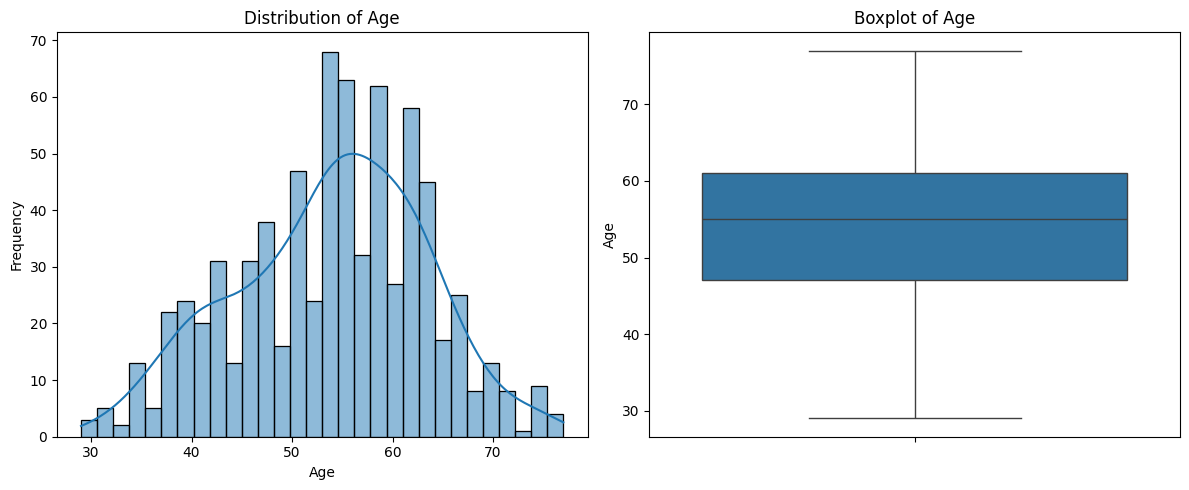


Statistic for Age
Skewness: -0.21
Kurtosis: -0.41


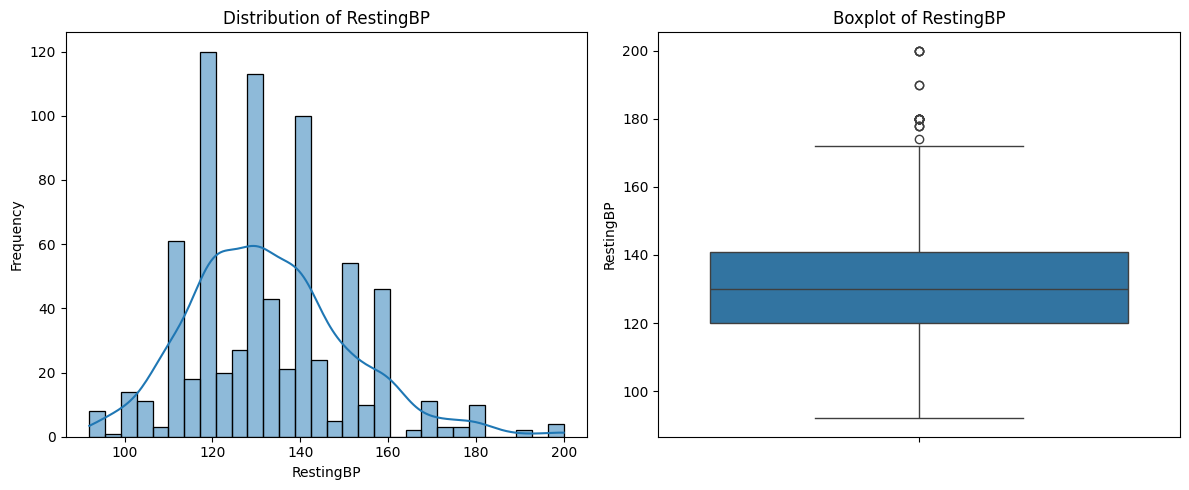


Statistic for RestingBP
Skewness: 0.63
Kurtosis: 0.73


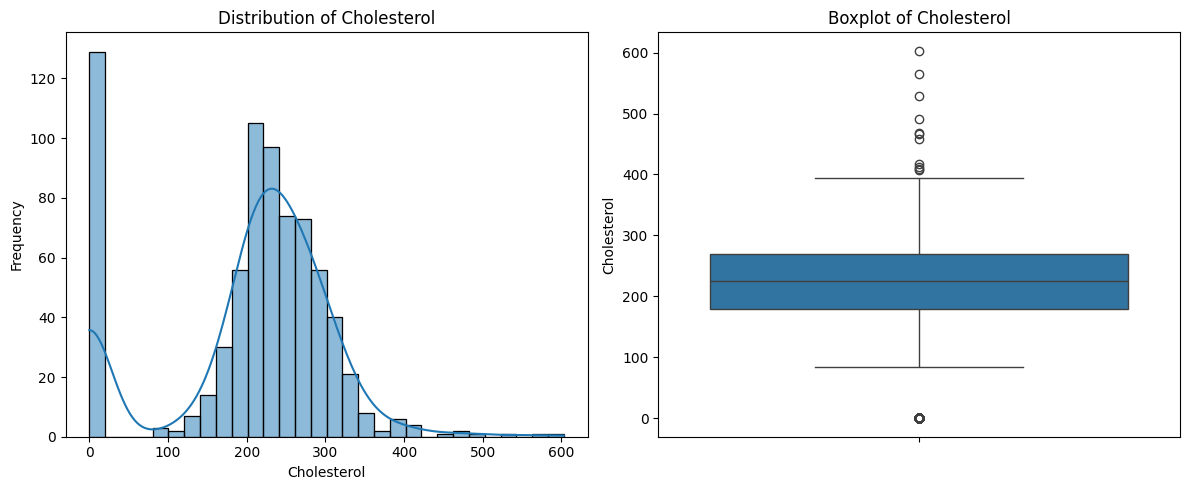


Statistic for Cholesterol
Skewness: -0.64
Kurtosis: 0.29


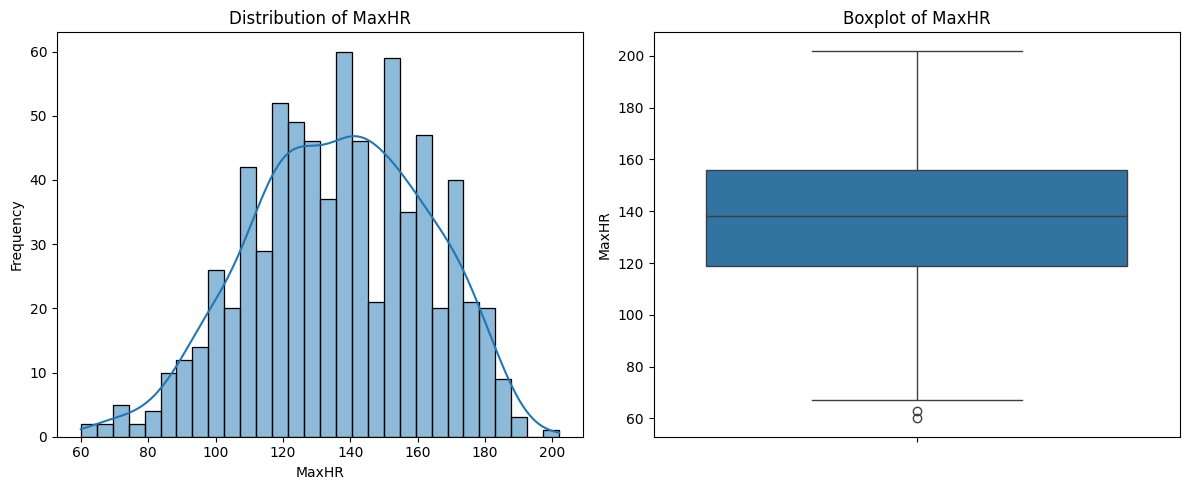


Statistic for MaxHR
Skewness: -0.19
Kurtosis: -0.46


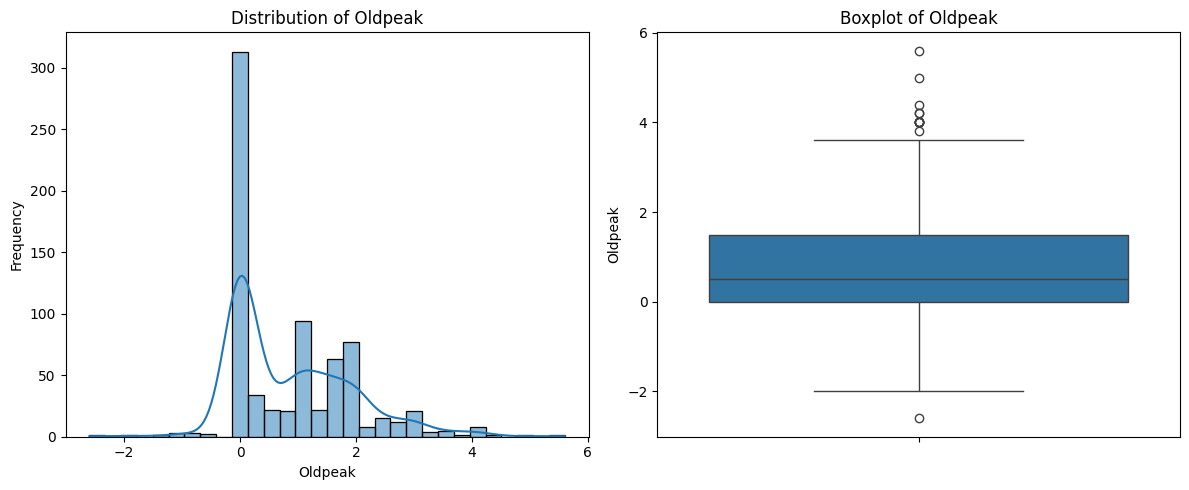


Statistic for Oldpeak
Skewness: 0.95
Kurtosis: 0.93


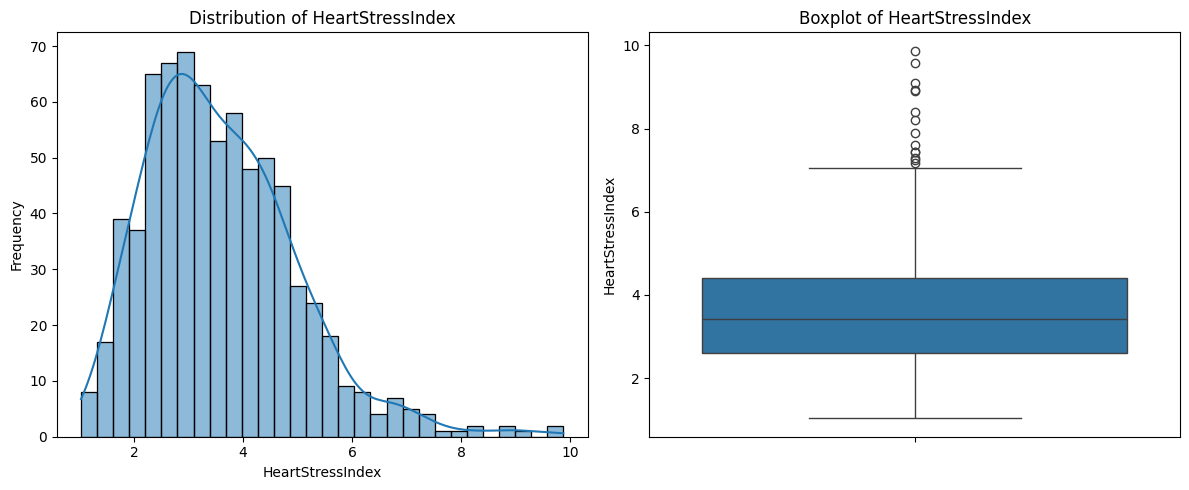


Statistic for HeartStressIndex
Skewness: 0.96
Kurtosis: 1.56


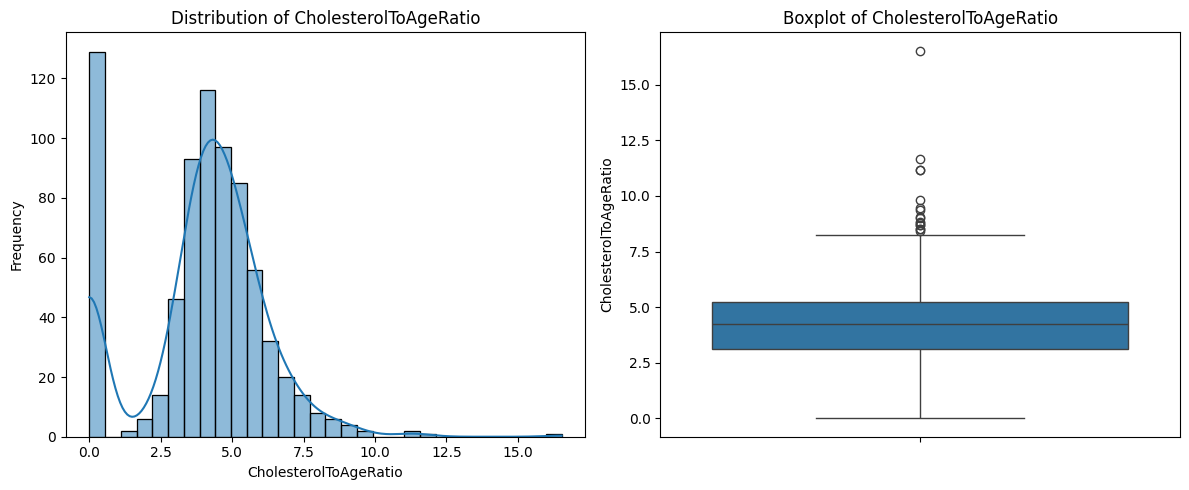


Statistic for CholesterolToAgeRatio
Skewness: -0.08
Kurtosis: 1.14


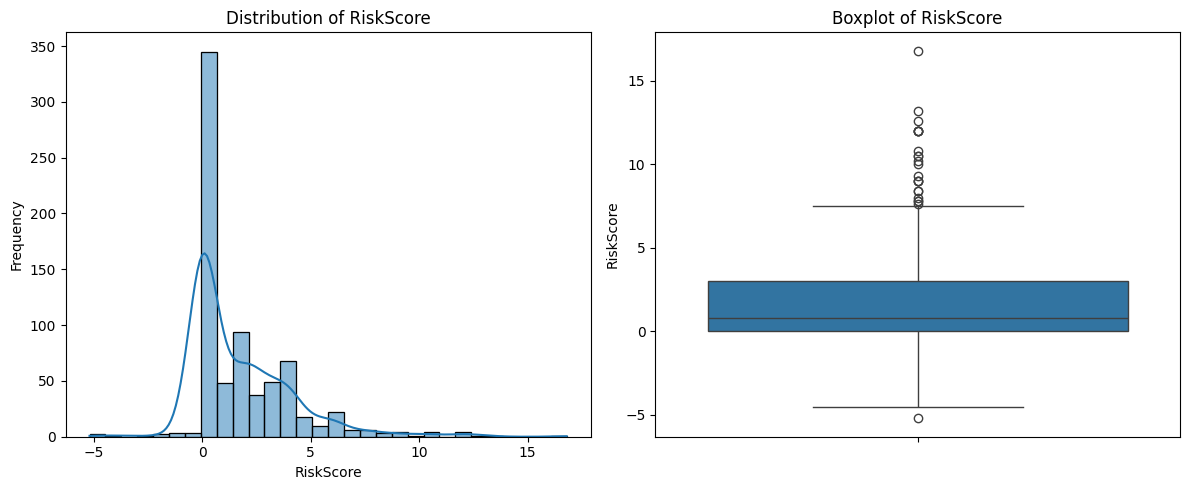


Statistic for RiskScore
Skewness: 1.79
Kurtosis: 4.92


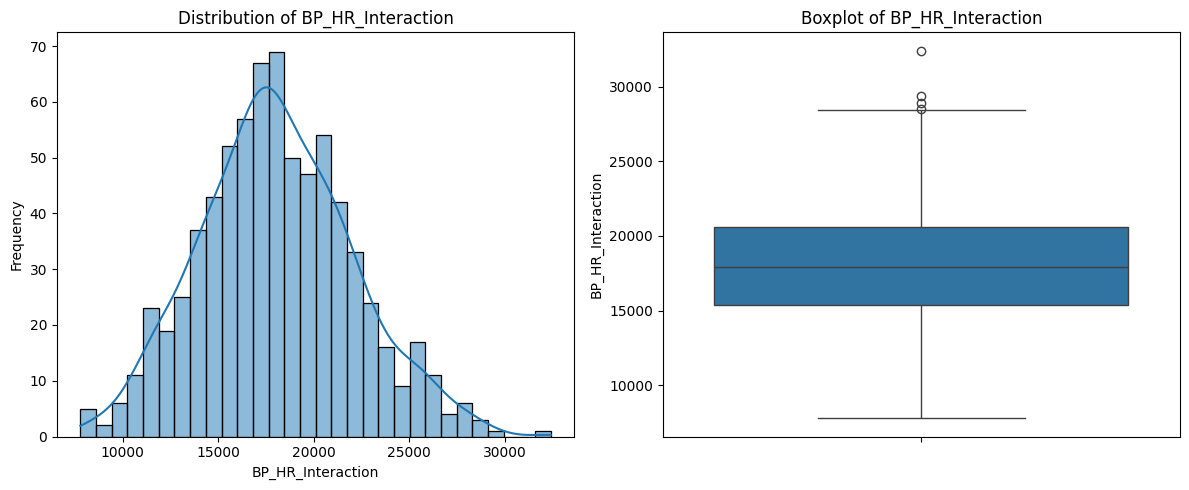


Statistic for BP_HR_Interaction
Skewness: 0.23
Kurtosis: -0.01


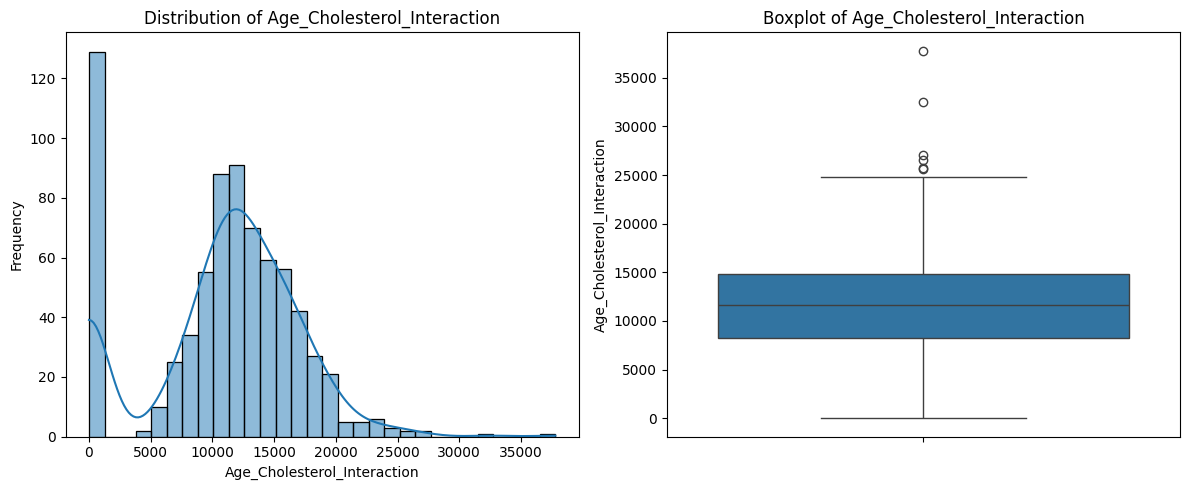


Statistic for Age_Cholesterol_Interaction
Skewness: -0.28
Kurtosis: 0.17


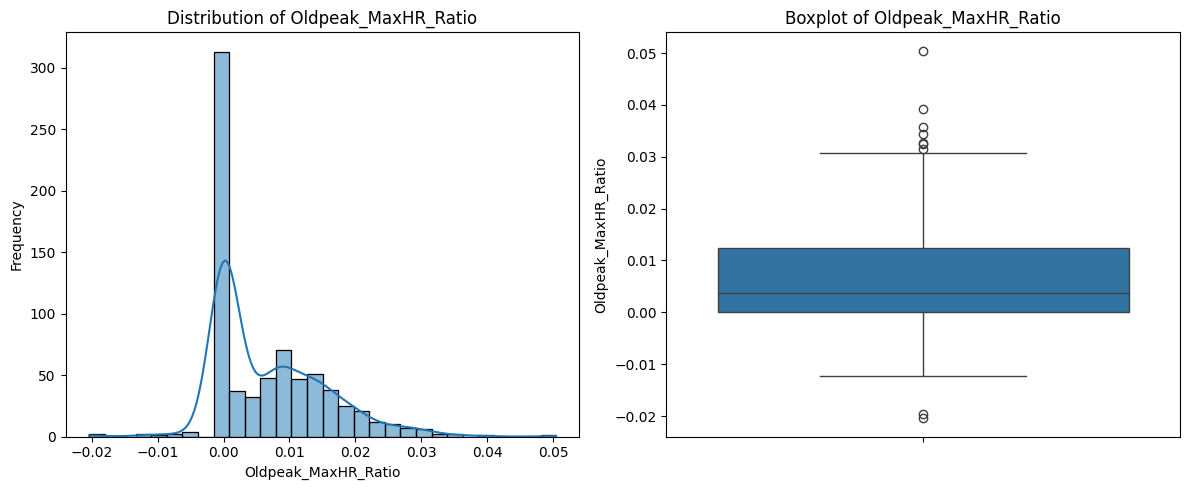


Statistic for Oldpeak_MaxHR_Ratio
Skewness: 1.00
Kurtosis: 1.30


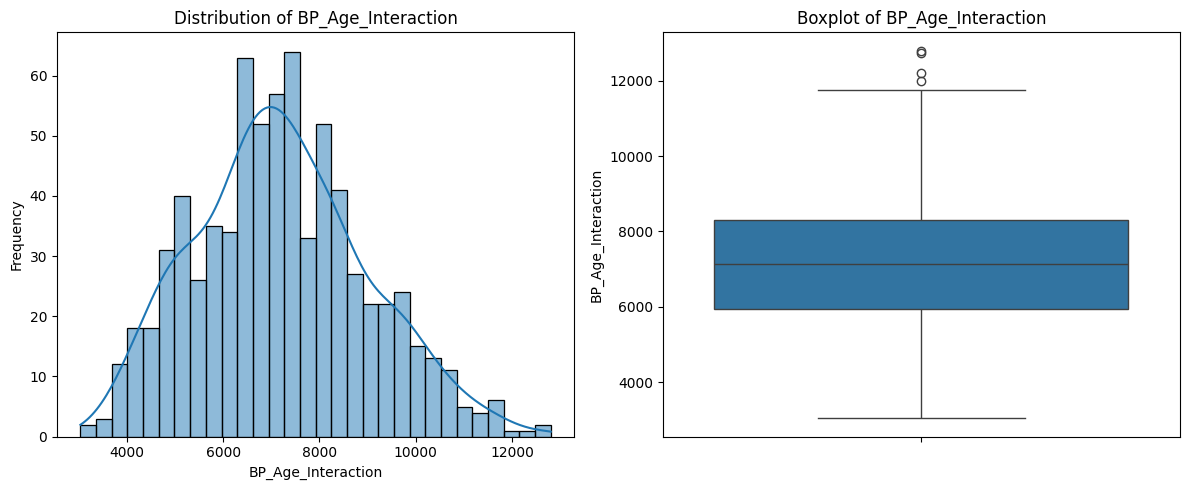


Statistic for BP_Age_Interaction
Skewness: 0.30
Kurtosis: -0.23


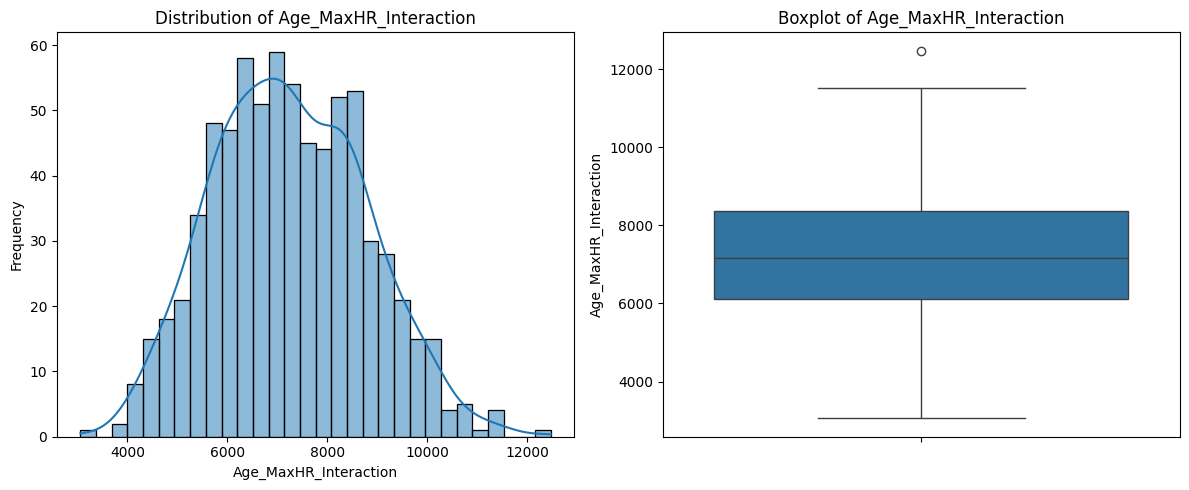


Statistic for Age_MaxHR_Interaction
Skewness: 0.20
Kurtosis: -0.31


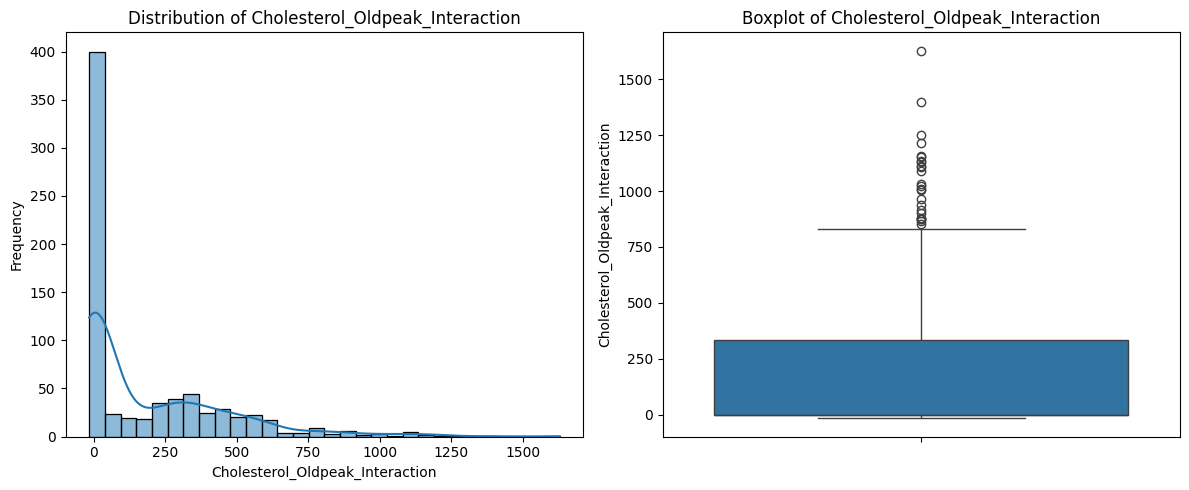


Statistic for Cholesterol_Oldpeak_Interaction
Skewness: 1.68
Kurtosis: 3.04


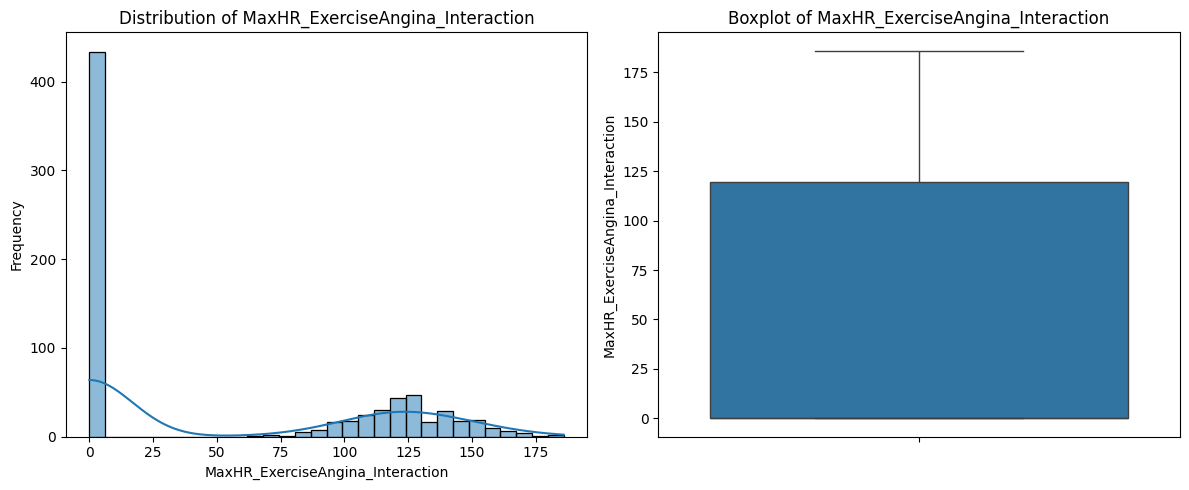


Statistic for MaxHR_ExerciseAngina_Interaction
Skewness: 0.51
Kurtosis: -1.57


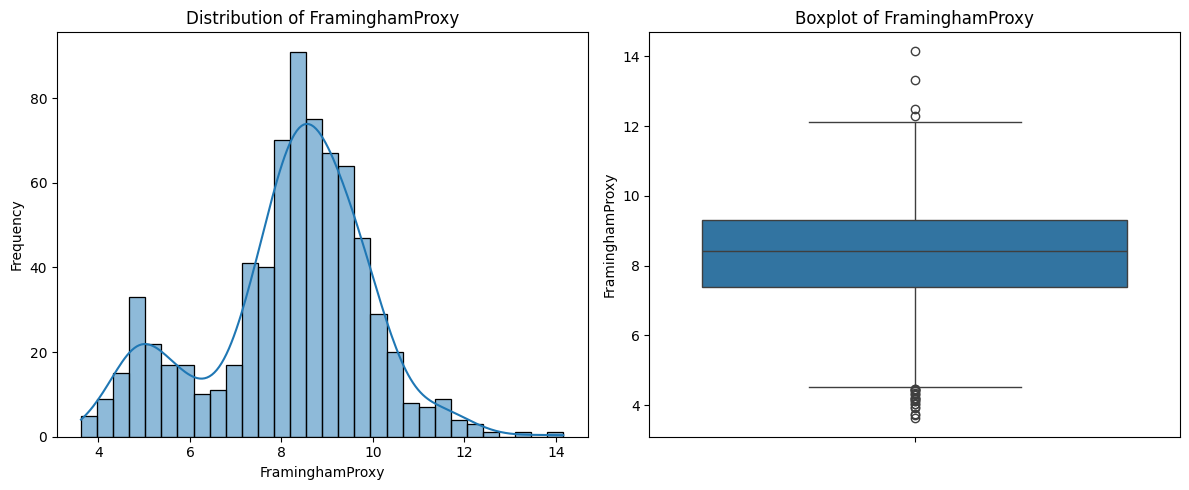


Statistic for FraminghamProxy
Skewness: -0.47
Kurtosis: 0.12


In [15]:
numerical_analysis(df_train, numerical_features)

In [16]:
transform_numerical_features = [
    "RestingBP", "Cholesterol", "Oldpeak", "HeartStressIndex",
    "CholesterolToAgeRatio", "RiskScore", "Age_Cholesterol_Interaction",
    "Oldpeak_MaxHR_Ratio", "Cholesterol_Oldpeak_Interaction",
    "MaxHR_ExerciseAngina_Interaction", "FraminghamProxy"
]

In [17]:
def categorical_analysis(df, categorical_features, target, n=10):
    for feature in categorical_features:
        plt.figure(figsize=(10, 4))
        nunique = df[feature].nunique()

        if nunique > n:
            top_categories = df[feature].value_counts().nlargest(n)
            stacked_data = pd.crosstab(df[feature], df[target])
            stacked_data = stacked_data.loc[top_categories.index]
            
            stacked_data.plot(
                kind='bar', stacked=True, figsize=(10, 6), color=sns.color_palette('cividis', len(stacked_data.columns)), width=0.8
            )
            plt.title(f"Top {n} Categories of {feature} (Stacked)")
            plt.xlabel(feature)
            plt.ylabel("Count")
        else:
            stacked_data = pd.crosstab(df[feature], df[target])
            stacked_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=sns.color_palette('cividis', len(stacked_data.columns)), width=0.8)
            plt.title(f"Distribution of {feature} (Stacked)")
            plt.xlabel(feature)
            plt.ylabel("Count")

        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

        print(f"\nStatistics for {feature}")
        print(f"Count: {nunique}")


<Figure size 1000x400 with 0 Axes>

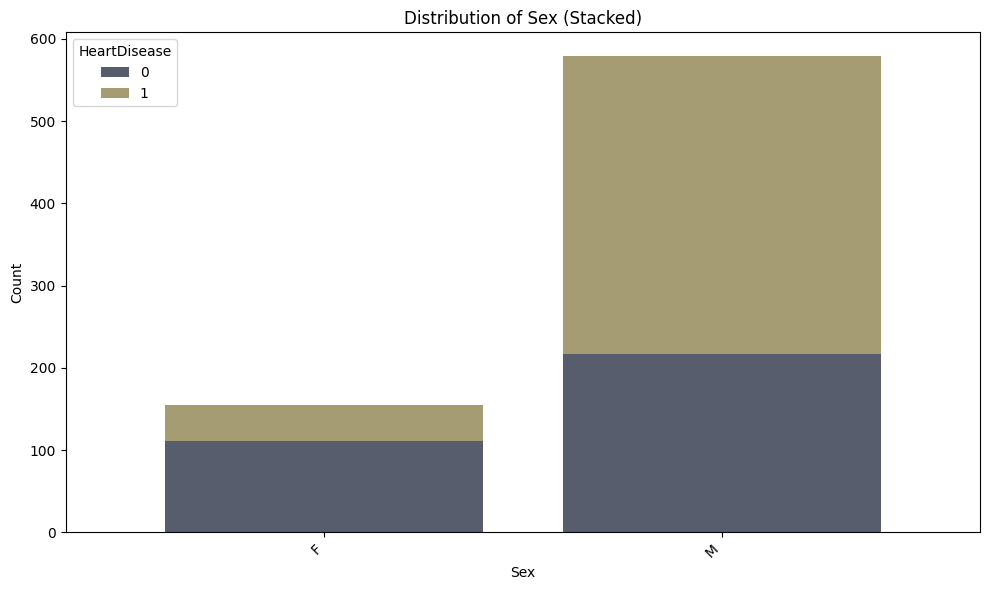


Statistics for Sex
Count: 2


<Figure size 1000x400 with 0 Axes>

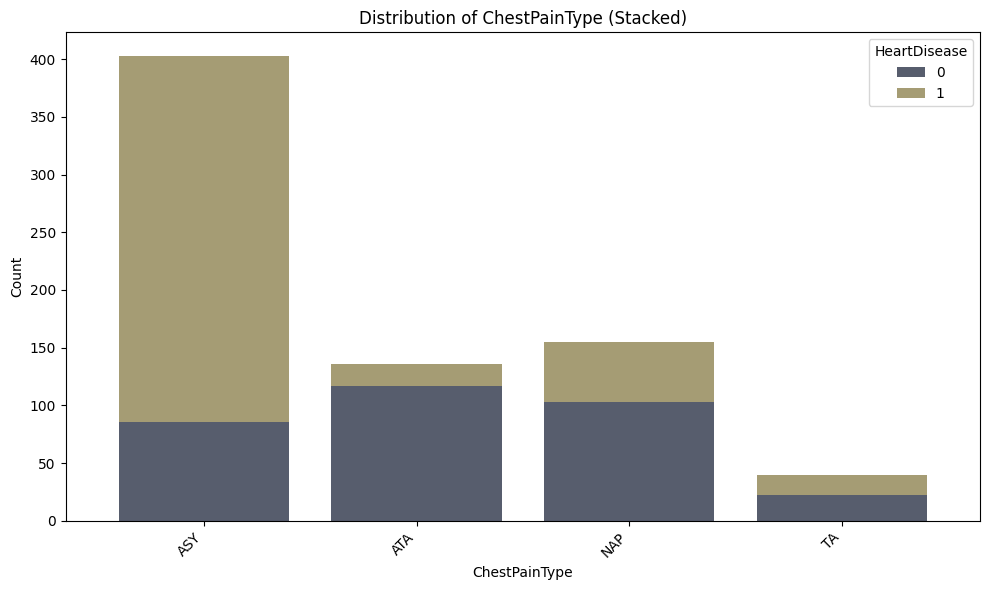


Statistics for ChestPainType
Count: 4


<Figure size 1000x400 with 0 Axes>

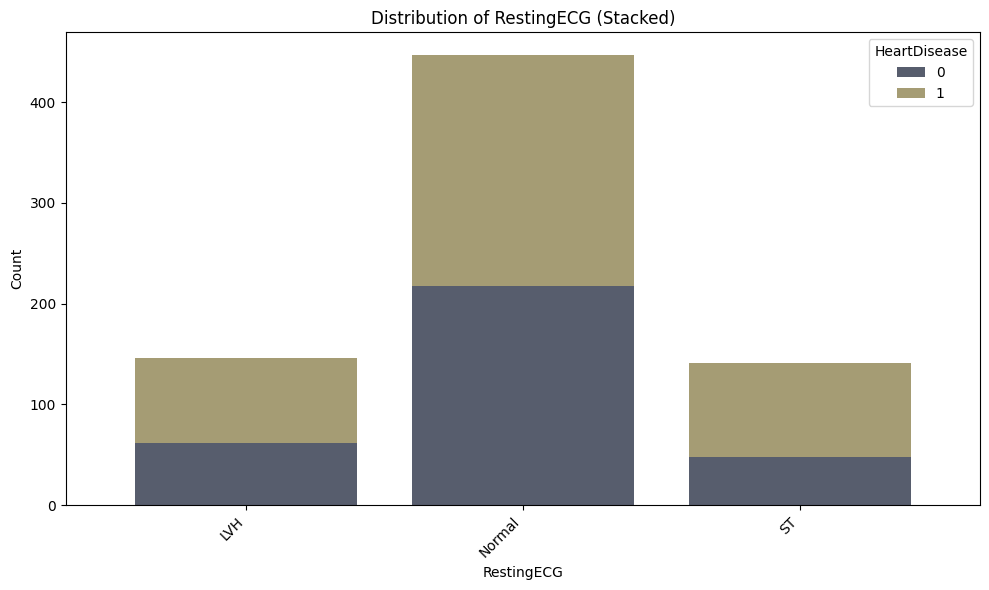


Statistics for RestingECG
Count: 3


<Figure size 1000x400 with 0 Axes>

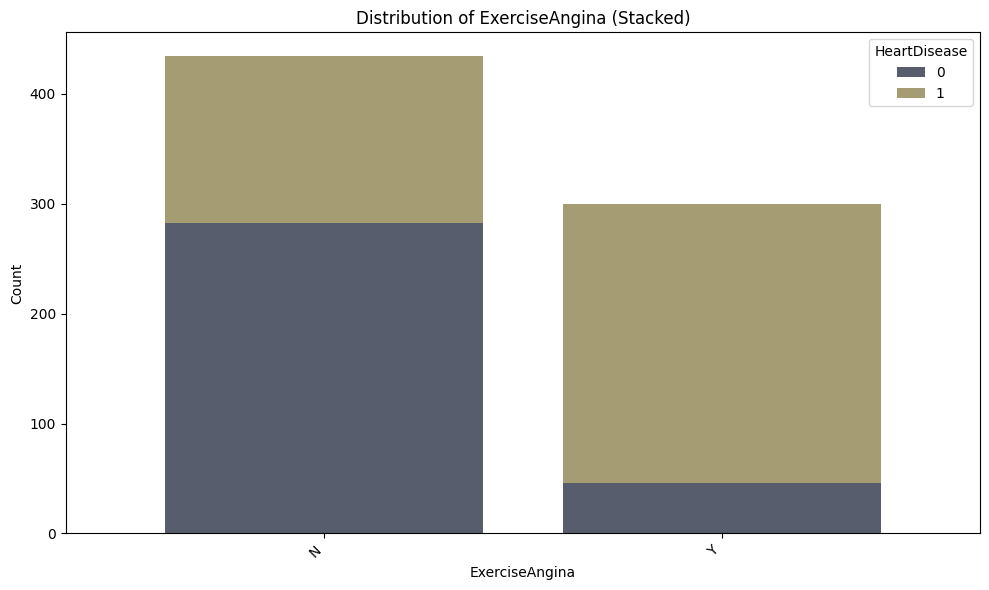


Statistics for ExerciseAngina
Count: 2


<Figure size 1000x400 with 0 Axes>

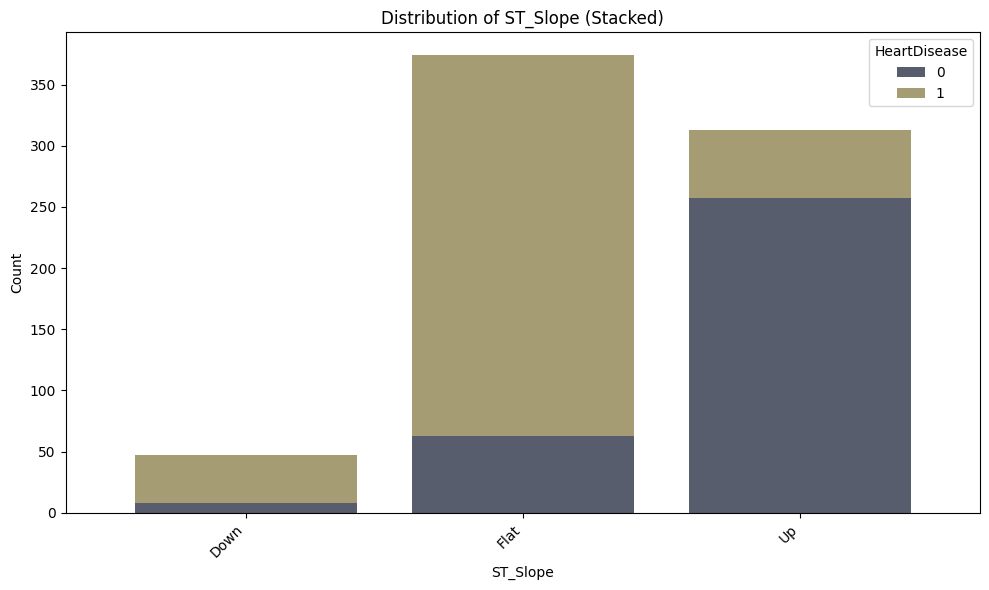


Statistics for ST_Slope
Count: 3


<Figure size 1000x400 with 0 Axes>

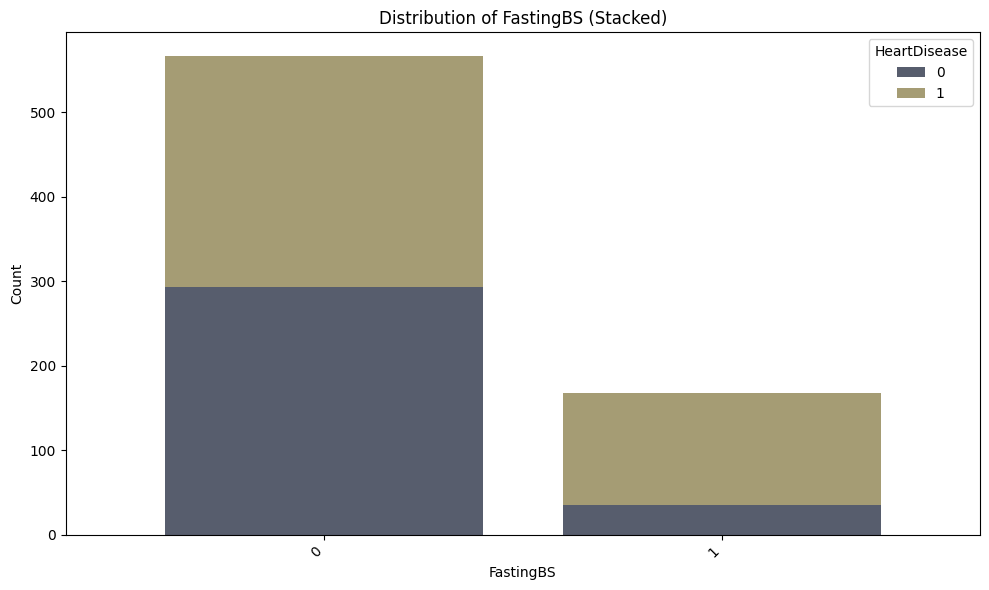


Statistics for FastingBS
Count: 2


In [18]:
categorical_analysis(df_train, categorical_features, target)

In [19]:
def numerical_correlation_with_target(df, features):
    correlation_matrix = df[features].corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    plt.figure(figsize=(max(8, len(features)), max(6, int(len(features) * 0.8))))

    sns.heatmap(
        correlation_matrix,
        mask=mask,
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        annot_kws={"size": 8},
        square=True,
        linewidth=0.5,
        cbar_kws={"shrink": 0.8}
    )

    plt.title("Correlation Plot")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

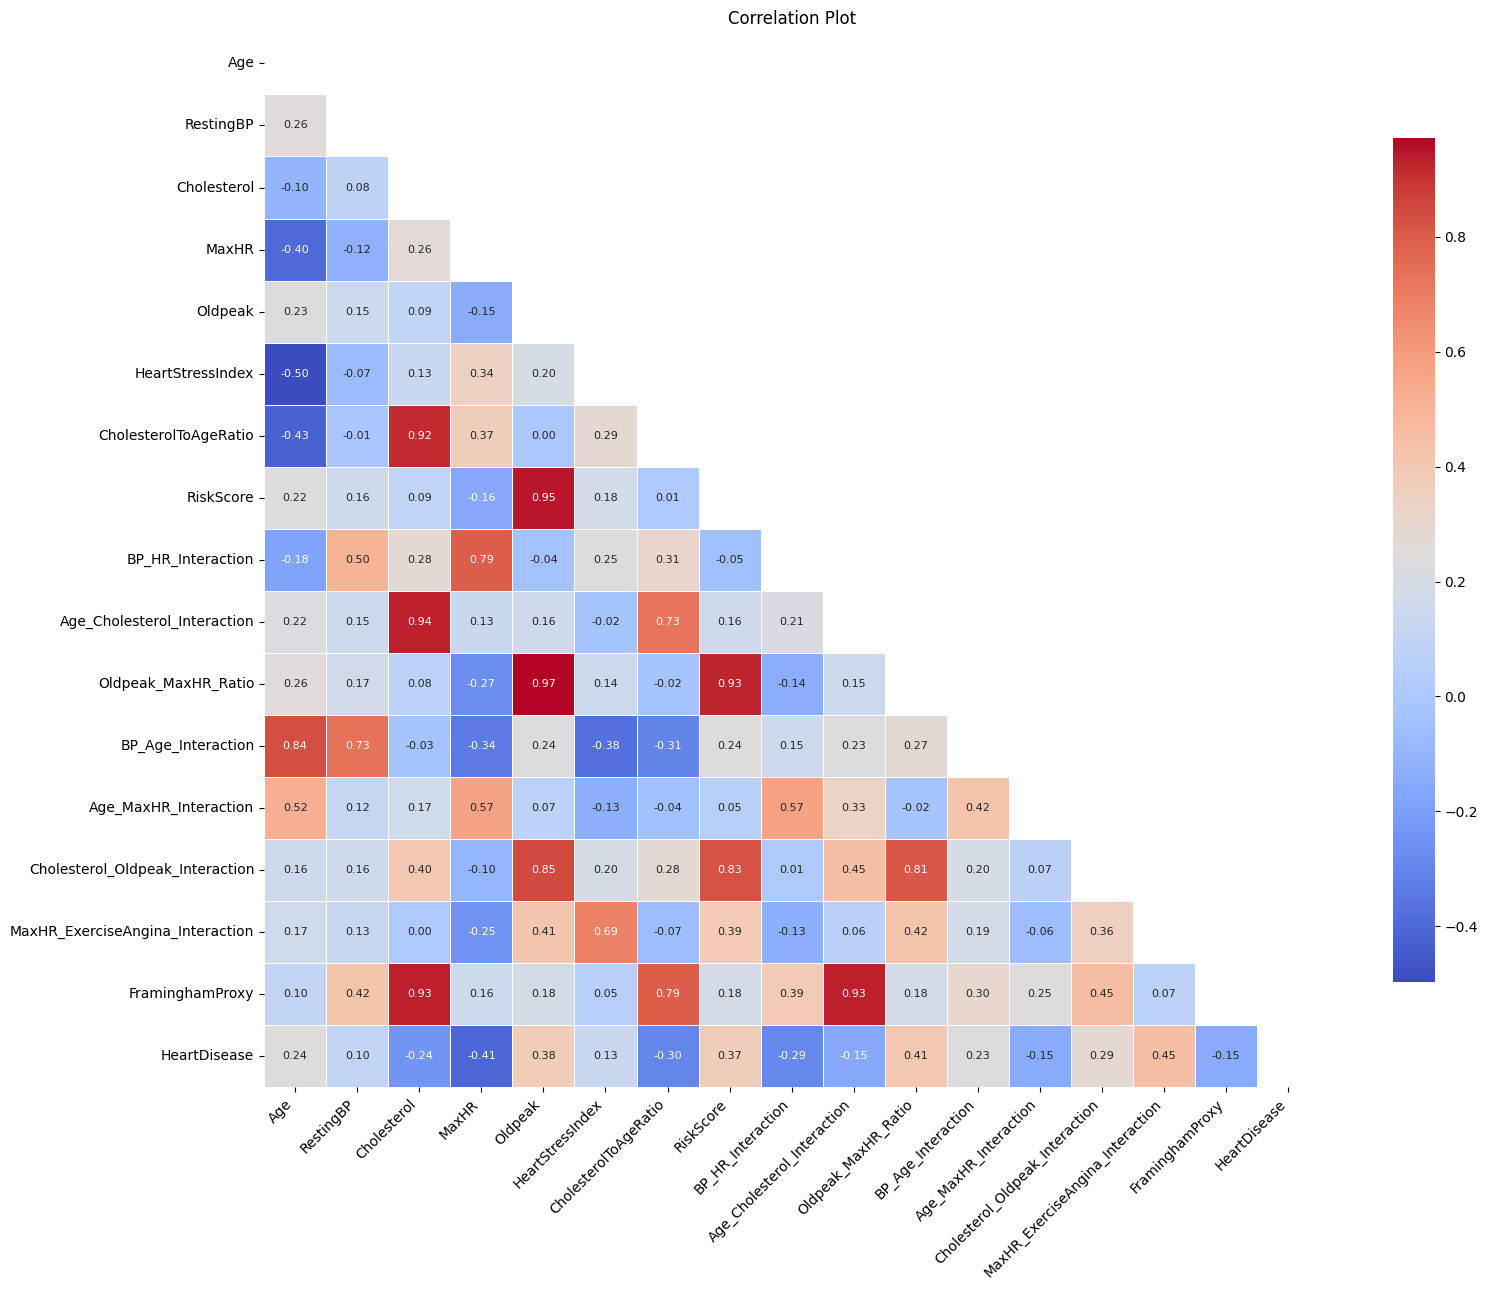

In [20]:
numerical_correlation_with_target(df_train, numerical_features + [target])

<span style='font-family:Georgia; font-size:20px; font-weight:bold;'>Base Models</span>

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [22]:
class SkewedFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, skewed_features, epsilon=1e-6):
        self.skewed_features = skewed_features
        self.epsilon = epsilon

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature in self.skewed_features:
            feature_data = X_transformed[feature]
            feature_data = np.where(feature_data <= 0, self.epsilon, feature_data)
            # X_transformed[feature] = np.log1p(X_transformed[feature] + self.epsilon)
            X_transformed[feature] = np.log1p(feature_data)
            
        return X_transformed

In [23]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [24]:
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("skewed", SkewedFeatureTransformer(transform_numerical_features)),
        ("scalar", StandardScaler())  
    ]), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

sampler = SMOTETomek(random_state=42)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, 
    HistGradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [62]:
X = df_train.drop(columns=['HeartDisease'])
y = df_train['HeartDisease']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss'),
    'Gradient Boosting': GradientBoostingClassifier(),
    'HistGradient Boosting': HistGradientBoostingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'MLPClassifier': MLPClassifier(max_iter=1000)
}

imputer = SimpleImputer(strategy='constant', fill_value=0)

results = []

for name, model in models.items():
    
    pipe = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('imputer', imputer),
        ('sampler', sampler),
        ('classifier', model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    y_proba = pipe.predict_proba(X_val)[:, 1]

    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)

    results.append({'Model': name, 'Accuracy': acc, 'F1 Score': f1, 'ROC AUC': auc})


results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False)
print(results_df)

<span style='font-family:Georgia; font-size:20px; font-weight:bold;'>Optimize Models with GridSearch</span>

In [57]:
gb_param_dist = {
    'classifier__loss': ['log_loss', 'exponential'],
    'classifier__learning_rate': np.logspace(-3, 0, 5),
    'classifier__n_estimators': randint(100, 500),
    'classifier__max_depth': randint(1, 10),
    'classifier__min_samples_split': randint(2, 10),
    'classifier__subsample': uniform(0.0, 1.0),
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__max_leaf_nodes': randint(2, 10),
}

lr_param_dist = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet', None],
    'classifier__l1_ratio': np.linspace(0.1, 0.9, 10),
    'classifier__C': np.logspace(-3, 2, 6),
    'classifier__fit_intercept': [True, False],
    'classifier__max_iter': randint(100, 1000),    
}

mlp_param_dist = {
    'classifier__hidden_layer_sizes': [
        (50,), (100,), (100, 50), (50, 50), (50, 50, 50),
        (100, 50, 25), (50, 100, 50), (50, 50, 25)
    ],
    'classifier__alpha': np.logspace(-5, 3, 9),
    'classifier__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'classifier__learning_rate_init': np.logspace(-5, 0, 6),
    'classifier__batch_size': ['auto', 8, 16, 32, 64],
    'classifier__beta_1': np.linspace(0.0, 0.9, 10),
    'classifier__beta_2': np.linspace(0.0, 0.999, 10),
    'classifier__epsilon': np.logspace(-10, 2, 12)
}

rf_param_dist = {
    'classifier__criterion': ['log_loss', 'entropy', 'gini'],
    # 'classifier__learning_rate': np.logspace(-3, 0, 5),
    'classifier__n_estimators': randint(100, 500),
    'classifier__max_depth': randint(1, 10),
    'classifier__min_samples_split': randint(2, 10),
    # 'classifier__subsample': uniform(0.0, 1.0),
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__max_leaf_nodes': randint(2, 10),
}

svc_param_dist = {
    'classifier__C': np.logspace(-3, 2, 6),
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],  
}

xgb_param_dist = {
    'classifier__n_estimators': randint(300, 1000),                 
    'classifier__learning_rate': loguniform(1e-3, 0.3),             
    'classifier__max_depth': randint(3, 15),                        
    'classifier__subsample': uniform(0.6, 0.4),                     
    'classifier__colsample_bytree': uniform(0.6, 0.4),              
    'classifier__gamma': loguniform(1e-8, 1.0),                     
    'classifier__reg_alpha': loguniform(1e-8, 10.0),                
    'classifier__reg_lambda': loguniform(1e-8, 10.0),               
    'classifier__min_child_weight': randint(1, 20),                
    'classifier__scale_pos_weight': loguniform(1.0, 50.0),        # useful in imbalanced datasets
    'classifier__max_delta_step': randint(0, 10),                 
}

histgb_param_dist = {
    'classifier__learning_rate': np.logspace(-3, 0, 5),
    'classifier__max_iter': randint(100, 500),
    'classifier__max_depth': randint(3, 15),
    'classifier__min_samples_leaf': randint(20, 100),
    'classifier__l2_regularization': loguniform(1e-5, 10.0),
    'classifier__max_leaf_nodes': randint(20, 100),
    'classifier__early_stopping': [True, False],
}


models_opt = {
    'Logistic Regression': (LogisticRegression(solver='saga', random_state=42, n_jobs=-1), lr_param_dist),
    'Random Forest': (RandomForestClassifier(random_state=42, n_jobs=-1), rf_param_dist),
    # 'Decision Tree': DecisionTreeClassifier(),
    # 'KNN': KNeighborsClassifier(),
    'SVM': (SVC(probability=True, class_weight='balanced', random_state=42), svc_param_dist),
    'XGBoost': (xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', random_state=42, n_jobs=-1), xgb_param_dist),
    'Gradient Boosting': (GradientBoostingClassifier(random_state=42), gb_param_dist),
    'HistGradient Boosting': (HistGradientBoostingClassifier(class_weight="balanced", random_state=43), histgb_param_dist),
    # 'AdaBoost': AdaBoostClassifier(),
    'MLPClassifier': (MLPClassifier(solver='adam', max_iter=2000, random_state=42), mlp_param_dist)
}

In [54]:
import warnings
warnings.filterwarnings("ignore")

imputer = SimpleImputer(strategy='constant', fill_value=0)

results = []

for name, (model, param_dist) in models_opt.items():
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    pipe = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('imputer', imputer),
        ('sampler', sampler),
        ('classifier', model)
    ])

    random_search = RandomizedSearchCV(
        pipe,
        param_distributions=param_dist,
        n_iter=100,
        cv=cv,
        scoring='roc_auc',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    random_search.fit(X_train, y_train)

    best_params = random_search.best_params_

    y_pred = random_search.predict(X_val)
    y_proba = random_search.predict_proba(X_val)[:, 1]

    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)

    results.append({'Model': name, 'Accuracy': acc, 'F1 Score': f1, 'ROC AUC': auc, 'Best Params': best_params})


results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False)
print(results_df)     

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
                   Model  Accuracy  F1 Score   ROC AUC  \
3                XGBoost  0.843537  0.867052  0.948373   
5  HistGradient Boosting  0.863946  0.876543  0.947811   
0    Logistic Regression  0.850340  0.860759  0.945380   
1          Random Forest  0.829932  0.852071  0.941264   
6          MLPClassifier  0.863946  0.875000  0.939207   
4      Gradient Boosting  0.857143  0.869565  0.938272   
2                    SVM  0.870748  0.881988  0.929293   

                                         Best Params  
3  {'classifier__colsample_bytree': 0.77

In [59]:
import optuna
from optuna.integration import OptunaSearchCV
from optuna.samplers import TPESampler

In [67]:
def objective(trial):
    classifier_name = trial.suggest_categorical("classifier_name", [
        'Logistic Regression', 'Random Forest', 'SVM', 'XGBoost',
        'Gradient Boosting', 'HistGradient Boosting', 'MLPClassifier'
    ])

    if classifier_name == 'Logistic Regression':
        classifier = LogisticRegression(solver='saga', random_state=42, n_jobs=-1)
        params = {
            'classifier__penalty': trial.suggest_categorical('lr__penalty', ['l1', 'l2', 'elasticnet']),
            'classifier__C': trial.suggest_loguniform('lr__C', 1e-3, 1e2),
            'classifier__l1_ratio': trial.suggest_float('lr__l1_ratio', 0.1, 0.9) if trial.params['lr__penalty'] == 'elasticnet' else None,
            'classifier__fit_intercept': trial.suggest_categorical('lr__fit_intercept', [True, False]),
            'classifier__max_iter': trial.suggest_int('lr__max_iter', 100, 1000)
        }

    elif classifier_name == 'Random Forest':
        classifier = RandomForestClassifier(random_state=42, n_jobs=-1)
        params = {
            'classifier__criterion': trial.suggest_categorical('rf__criterion', ['log_loss', 'entropy', 'gini']),
            'classifier__n_estimators': trial.suggest_int('rf__n_estimators', 100, 500),
            'classifier__max_depth': trial.suggest_int('rf__max_depth', 1, 10),
            'classifier__min_samples_split': trial.suggest_int('rf__min_samples_split', 2, 10),
            'classifier__max_features': trial.suggest_categorical('rf__max_features', ['sqrt', 'log2', None]),
            'classifier__max_leaf_nodes': trial.suggest_int('rf__max_leaf_nodes', 2, 10)
        }

    elif classifier_name == 'SVM':
        classifier = SVC(probability=True, class_weight='balanced', random_state=42)
        params = {
            'classifier__C': trial.suggest_loguniform('svm__C', 1e-3, 1e2),
            'classifier__kernel': trial.suggest_categorical('svm__kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        }

    elif classifier_name == 'XGBoost':
        classifier = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', random_state=42, n_jobs=-1)
        params = {
            'classifier__n_estimators': trial.suggest_int('xgb__n_estimators', 300, 1000),
            'classifier__learning_rate': trial.suggest_loguniform('xgb__learning_rate', 1e-3, 0.3),
            'classifier__max_depth': trial.suggest_int('xgb__max_depth', 3, 15),
            'classifier__subsample': trial.suggest_float('xgb__subsample', 0.6, 1.0),
            'classifier__colsample_bytree': trial.suggest_float('xgb__colsample_bytree', 0.6, 1.0),
            'classifier__gamma': trial.suggest_loguniform('xgb__gamma', 1e-8, 1.0),
            'classifier__reg_alpha': trial.suggest_loguniform('xgb__reg_alpha', 1e-8, 10.0),
            'classifier__reg_lambda': trial.suggest_loguniform('xgb__reg_lambda', 1e-8, 10.0),
            'classifier__min_child_weight': trial.suggest_int('xgb__min_child_weight', 1, 20),
            'classifier__scale_pos_weight': trial.suggest_loguniform('xgb__scale_pos_weight', 1.0, 50.0),
            'classifier__max_delta_step': trial.suggest_int('xgb__max_delta_step', 0, 10)
        }

    elif classifier_name == 'Gradient Boosting':
        classifier = GradientBoostingClassifier(random_state=42)
        params = {
            'classifier__loss': trial.suggest_categorical('gb__loss', ['log_loss', 'exponential']),
            'classifier__learning_rate': trial.suggest_loguniform('gb__learning_rate', 1e-3, 1.0),
            'classifier__n_estimators': trial.suggest_int('gb__n_estimators', 100, 500),
            'classifier__max_depth': trial.suggest_int('gb__max_depth', 1, 10),
            'classifier__min_samples_split': trial.suggest_int('gb__min_samples_split', 2, 10),
            'classifier__subsample': trial.suggest_uniform('gb__subsample', 0.0, 1.0),
            'classifier__max_features': trial.suggest_categorical('gb__max_features', ['sqrt', 'log2', None]),
            'classifier__max_leaf_nodes': trial.suggest_int('gb__max_leaf_nodes', 2, 10)
        }

    elif classifier_name == 'HistGradient Boosting':
        classifier = HistGradientBoostingClassifier(random_state=42)
        params = {
            'classifier__learning_rate': trial.suggest_loguniform('hb__learning_rate', 1e-3, 1.0),
            'classifier__max_iter': trial.suggest_int('hb__max_iter', 100, 500),
            'classifier__max_depth': trial.suggest_int('hb__max_depth', 3, 15),
            'classifier__min_samples_leaf': trial.suggest_int('hb__min_samples_leaf', 20, 100),
            'classifier__l2_regularization': trial.suggest_loguniform('hb__l2_regularization', 1e-5, 10.0),
            'classifier__max_leaf_nodes': trial.suggest_int('hb__max_leaf_nodes', 20, 100),
            'classifier__early_stopping': trial.suggest_categorical('hb__early_stopping', [True, False])
        }

    elif classifier_name == 'MLPClassifier':
        classifier = MLPClassifier(solver='adam', max_iter=2000, random_state=42)
        params = {
            'classifier__hidden_layer_sizes': trial.suggest_categorical('mlp__hidden_layer_sizes', [
                (50,), (100,), (100, 50), (50, 50), (50, 50, 50),
                (100, 50, 25), (50, 100, 50), (50, 50, 25)
            ]),
            'classifier__alpha': trial.suggest_loguniform('mlp__alpha', 1e-5, 1e3),
            'classifier__learning_rate': trial.suggest_categorical('mlp__learning_rate', ['constant', 'invscaling', 'adaptive']),
            'classifier__learning_rate_init': trial.suggest_loguniform('mlp__learning_rate_init', 1e-5, 1.0),
            'classifier__batch_size': trial.suggest_categorical('mlp__batch_size', ['auto', 8, 16, 32, 64]),
            'classifier__beta_1': trial.suggest_float('mlp__beta_1', 0.0, 0.9),
            'classifier__beta_2': trial.suggest_float('mlp__beta_2', 0.0, 0.999),
            'classifier__epsilon': trial.suggest_loguniform('mlp__epsilon', 1e-10, 1e2)
        }

    pipe = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('sampler', sampler),
        ('classifier', classifier)
    ])

    pipe.set_params(**{k: v for k, v in params.items() if v is not None})

    pipe.fit(X_train, y_train)

    y_proba = pipe.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_proba)

    return auc


In [68]:
study = optuna.create_study(
    direction="maximize",  
    sampler=TPESampler(seed=42)  # Can use RandomSampler or CMAESampler
)

study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2025-05-14 02:24:10,937] A new study created in memory with name: no-name-d9efd1fa-0caa-415a-a5e1-1b75451d7597
[I 2025-05-14 02:24:11,392] Trial 1 finished with value: 0.9017957351290684 and parameters: {'classifier_name': 'SVM', 'svm__C': 86.46404440335792, 'svm__kernel': 'poly'}. Best is trial 1 with value: 0.9017957351290684.
[I 2025-05-14 02:24:11,620] Trial 0 finished with value: 0.9498690609801721 and parameters: {'classifier_name': 'Logistic Regression', 'lr__penalty': 'l2', 'lr__C': 9.372812593691826, 'lr__fit_intercept': True, 'lr__max_iter': 443}. Best is trial 0 with value: 0.9498690609801721.
[I 2025-05-14 02:24:11,796] Trial 3 finished with value: 0.9487467265245042 and parameters: {'classifier_name': 'Logistic Regression', 'lr__penalty': 'l1', 'lr__C': 46.20822545058018, 'lr__fit_intercept': True, 'lr__max_iter': 527}. Best is trial 0 with value: 0.9498690609801721.
[I 2025-05-14 02:24:12,533] Trial 2 finished with value: 0.94668911335578 and parameters: {'classifier_n

In [69]:
print("Best trial:")
trial = study.best_trial

print(f"AUC: {trial.value}")
print("Best classifier and params:")
for key, value in trial.params.items():
    print(f"  {key}: {value}")


Best trial:
AUC: 0.9508043396932286
Best classifier and params:
  classifier_name: Logistic Regression
  lr__penalty: l1
  lr__C: 2.885683416210471
  lr__fit_intercept: True
  lr__max_iter: 365


In [108]:
def update_params(params):
    
    updated_params = {}
    
    for k, v in params.items():
        new_key = (
            k.replace("lr__", "")
            .replace("rf__", "")
            .replace("xgb__", "")
            .replace("svm__", "")
            .replace("gb__", "")
            .replace("hb__", "")
            .replace("mlp__", "")
        )
        
        updated_params[new_key] = v
        
    return updated_params



def get_model(trial=None, classifier_name=None, best_params=None):

    if not classifier_name:
        best_params = trial.params.copy()
        classifier_name = best_params.pop("classifier_name")

    best_params = update_params(best_params)
    
    if classifier_name == "Random Forest":       
        classifier = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
    elif classifier_name == "XGBoost":
        classifier = xgb.XGBClassifier(**best_params, objective='binary:logistic', eval_metric='auc', random_state=42, n_jobs=-1)
    elif classifier_name == "Logistic Regression":
        classifier = LogisticRegression(**best_params, solver='saga', random_state=42, n_jobs=-1)
    elif classifer_name == "SVM":
        classifier = SVC(**best_params, probability=True, class_weight='balanced', random_state=42)
    elif classifier_name == "Gradient Boosting":
        classifier = GradientBoostingClassifier(**best_params, random_state=42)
    elif classifier_name == "HistGradient Boosting":
        classifier = HistGradientBoostingClassifier(**best_params, random_state=42)
    elif classifier_name == "MLPClassifier":
        classifier = MLPClassifier(**best_params, solver='adam', max_iter=2000, random_state=42)
    else:
        raise ValueError(f"Unsupported classifier: {classifier_name}")

    return name, classifier

In [93]:
best_params = study.best_trial.params.copy()
best_classifier_name = best_params.pop("classifier_name")

_, classifier = get_model(classifier_name=best_classifier_name, best_params=best_params)
    
pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('sampler', sampler),
    ('classifier', classifier)
])


pipe.fit(X_train, y_train)

y_proba = pipe.predict(X_val)
y_proba = pipe.predict_proba(X_val)[:, 1]

print("Final Model Evaluation:")
print(classification_report(y_test, y_pred))
auc = roc_auc_score(y_val, y_proba)
auc

Final Model Evaluation:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84        66
           1       0.87      0.88      0.87        81

    accuracy                           0.86       147
   macro avg       0.86      0.85      0.86       147
weighted avg       0.86      0.86      0.86       147



np.float64(0.9508043396932286)

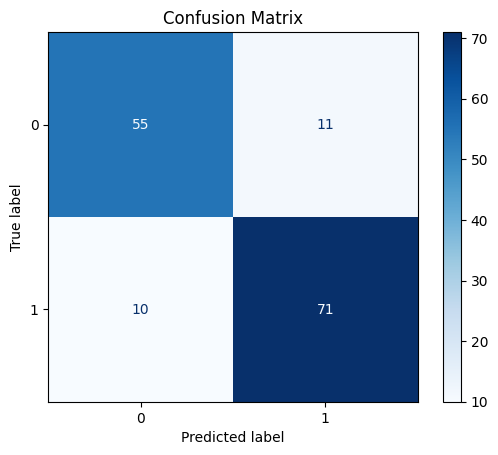

In [126]:
cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues') 
plt.title("Confusion Matrix")
plt.show()

In [116]:
top_n = 3
estimators = []
i = 0
for trial in sorted(study.trials, key=lambda t: t.value, reverse=True)[:top_n]:
    name, model = get_model(trial=trial)
    estimators.append((f"{name}_{i}", model))
    i+= 1

In [110]:
from sklearn.ensemble import StackingClassifier

In [122]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(**update_params(best_params), solver='saga', random_state=42, n_jobs=-1),
    cv=cv,
    passthrough=True,
    n_jobs=-1
)

# Fit stacking pipeline
stacking_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('sampler', sampler),
    ('classifier', classifier)
])

stacking_pipe.fit(X_train, y_train)
stacked_pred = stacking_pipe.predict(X_val)
stacked_proba = stacking_pipe.predict_proba(X_val)[:, 1]

In [123]:
print("Stacked Final Model Evaluation:")
print(classification_report(y_val, stacked_pred))
auc = roc_auc_score(y_val, stacked_proba)
auc

Stacked Final Model Evaluation:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87        66
           1       0.90      0.88      0.89        81

    accuracy                           0.88       147
   macro avg       0.88      0.88      0.88       147
weighted avg       0.88      0.88      0.88       147



np.float64(0.9508043396932286)

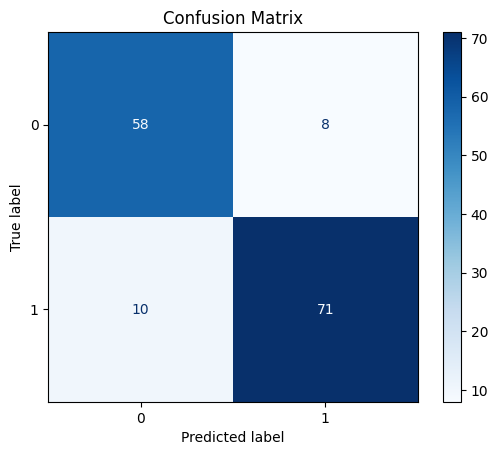

In [125]:
cm = confusion_matrix(y_val, stacked_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues') 
plt.title("Confusion Matrix")
plt.show()